# Introduction to Bedrock - Generating images using Stable Diffusion

> *If you see errors, you may need to be allow-listed for the Bedrock models used by this notebook*

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*


--- 

In this demo notebook, we demonstrate how to use the Bedrock Python SDK for a image generation task. We show how to use The Stable Diffusion foundational model to create images

---

Note: This notebook was tested in Amazon SageMaker Studio with Python 3 (Data Science 2.0) kernel.

1. [Set Up](#1.-Set-Up-and-API-walkthrough)
2. [Image Creation](#2.-Generate-Images-with-Text)
3. [Image to Image](#3.-Image-to-Image) 

## 1. Set Up and API walkthrough

---
Before executing the notebook for the first time, execute this cell to add bedrock extensions to the Python boto3 SDK

---

In [2]:
%pip install -U boto3 botocore --quiet --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
awscli 1.29.42 requires botocore==1.31.42, but you have botocore 1.31.63 which is incompatible.
awscli 1.29.42 requires s3transfer<0.7.0,>=0.6.0, but you have s3transfer 0.7.0 which is incompatible.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.3.3 which is incompatible.
jupyterlab 3.4.4 requires jupyter-server~=1.16, but you have jupyter-server 2.7.3 which is incompatible.
jupyterlab-server 2.10.3 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
notebook 6.5.5 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.3.1 which is incompatible.
notebook 6.5.5 requires pyzmq<25,>=17, but you have pyzmq 25.1.1 which is inc

#### Now let's set up our connection to the Amazon Bedrock SDK using Boto3

In [3]:
#### Un comment the following lines to run from your local environment outside of the AWS account with Bedrock access

#import os
#os.environ['BEDROCK_ASSUME_ROLE'] = '<YOUR_VALUES>'
#os.environ['AWS_PROFILE'] = '<YOUR_VALUES>'

#### In this Notebook we will be using the invoke_model() method of Amazon Bedrock. This will be the primary method we use for most of our Image  Generation and Processing tasks. 

##### The mandatory parameters required to use this method are, where _modelId_ represents the Amazon Bedrock model ARN, and _body_ which is the prompt for our task. The _body_ prompt will change depending on the foundational model provider selected. We walk through this in detail below

```
{
   modelId=model_id,
   contentType="application/json",
   accept="application/json",
   body=body
}

```

## 2. Generate Images with Text

#### Let's now try out the Stable Diffusion model in Amazon Bedrock to generate some images with text

In [6]:
import boto3
import json
import os
import sys

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

bedrock_client = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=True # Default. Needed for invoke_model() from the data plane
)

Create new client
  Using region: us-west-2
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)


In [7]:
prompt_data ="Golden retriever playing catch at a tropical, sunny beach with palm trees in the background."

In [8]:
negative_prompts = [
    "3d render", "smooth", "plastic", "blurry", "grainy", 
    "low-resolution", "anime", "deep-fried", "oversaturated", 
    "poorly rendered", "poor background details", "poorly drawn dog",
    "disfigured dog features"
    ]

In [9]:
style_preset = "photographic"

In [10]:
from botocore.config import Config
from botocore.exceptions import ClientError
import json
from PIL import Image
from io import BytesIO
import base64
from base64 import b64encode
from base64 import b64decode
import boto3


body = json.dumps(
    {"text_prompts":[{"text":prompt_data}],
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
) 

modelId = 'stability.stable-diffusion-xl'
accept = 'application/json'
contentType = 'application/json'

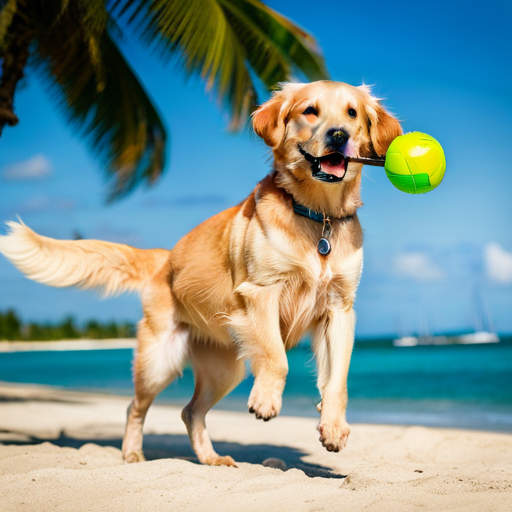

In [11]:
response = bedrock_client.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response = json.loads(response.get('body').read())
images = response.get('artifacts')

image = Image.open(BytesIO(b64decode(images[0].get('base64'))))
image.save("generated_image.png")
display(image)

## 3. Image to Image

#### Stable Diffusion let's us do some interesting stuff with our images like adding new characters or modifying scenery let's give it a try

In [12]:
prompt_data = "Change the dog to be a poodle"

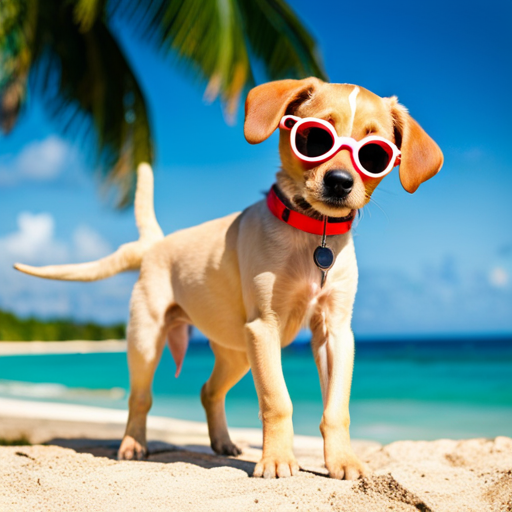

In [13]:
buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps(
    {"text_prompts":[{"text": prompt_data }],
     "init_image": base64.b64encode(img_bytes).decode(),
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
)
modelId = 'stability.stable-diffusion-xl'

try: 
    response = bedrock_client.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)

if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'converted.png'
#save file
image.save(file_name)
display(image)

## Create different image from Golden Retriever

In [14]:
prompt_data = "Remove the ball from the image"

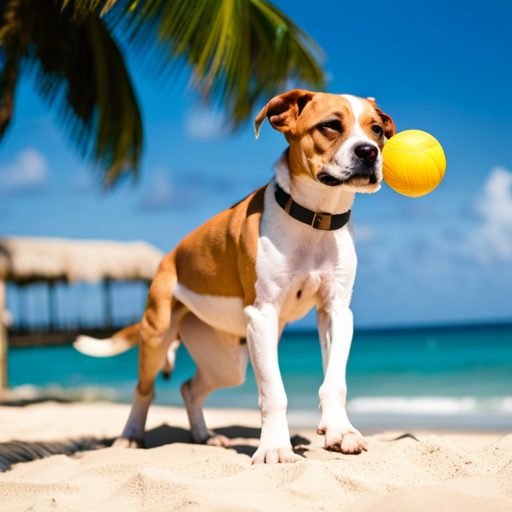

In [15]:
buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps(
    {"text_prompts":[{"text": prompt_data }],
     "init_image": base64.b64encode(img_bytes).decode(),
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
)
modelId = 'stability.stable-diffusion-xl'

try: 
    response = bedrock_client.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)

if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'converted-to-mountains.png'
#save file
image.save(file_name)
display(image)

In [16]:
prompt_data = "Upscale to 8K resolution"

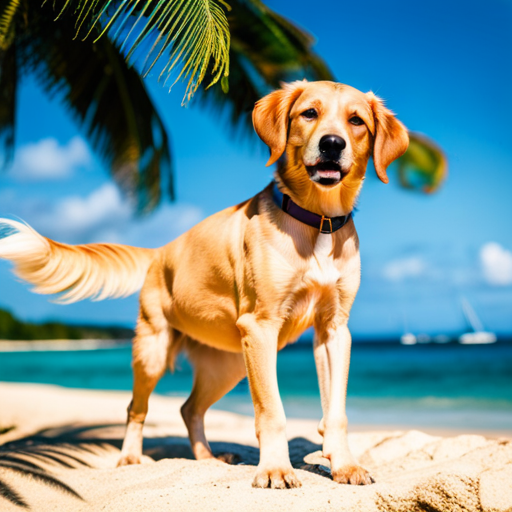

In [17]:
buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps(
    {"text_prompts":[{"text": prompt_data }],
     "init_image": base64.b64encode(img_bytes).decode(),
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
)
modelId = 'stability.stable-diffusion-xl'

try: 
    response = bedrock_client.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)

if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'upscaled-to-8k.png'
#save file
image.save(file_name)
display(image)